# Notebook to accompany the forecasting module MATH6011M at the University of Southampton.
https://www.southampton.ac.uk/courses/modules/math6011

aeon is a python toolkit for time series machine learning, including forecasting. We
will show you how to use aeon to enhance your understanding of the module. These
examples are based on the material provided for the module https://link.springer.com/article/10.1007/s43069-022-00179-z and have been developed in collaboration with the module organiser, Alain Zemkoho.

If you have any questions, please join our slack and ask in the #math6011 channel, we
 are more than happy to help.


## 1. Getting started with aeon

Install, create environment and import the necessary packages.

## Plotting and basic analysis (Section 2.2)

The classic Box & Jenkins airline data. It represents monthly totals of international
 airline passengers, in thousandsm from 1949 to 1960. This dataset is used in many text
books.  This data shows an increasing trend,non-constant (increasing) variance and
periodic, seasonal patterns. The data is stored as a pandas Series object, which
stores both the time index and the value (the time index is a pandas
PeriodIndex, but statsdmodels requires DatetimeIndex, hence the conversion on line 7).

In [19]:
import pandas as pd
import statsmodels.api as sm

from aeon.datasets import load_airline

airline = load_airline()
type(airline)
airline.head()
airline.index = airline.index.to_timestamp()

The data shows an increasing trend, non-constant (increasing) variance and periodic,
seasonal patterns.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

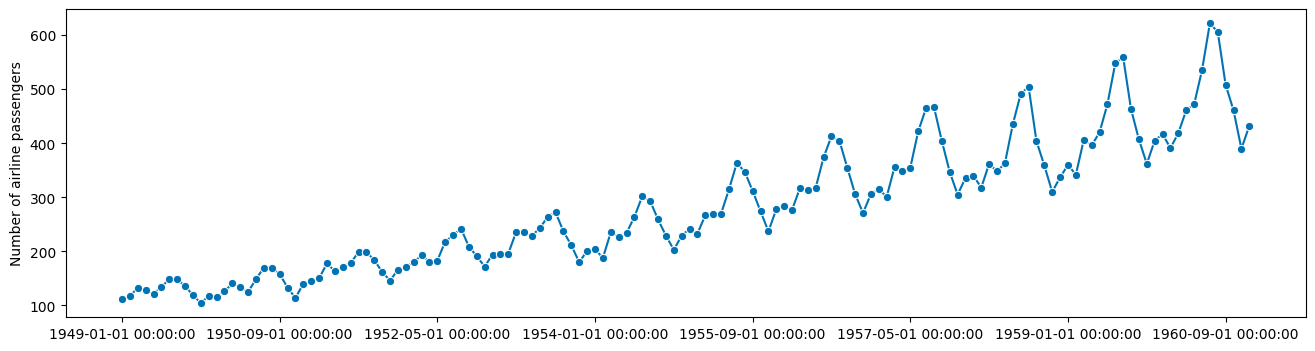

In [20]:
from aeon.utils.plotting import plot_series

plot_series(airline)

## Decomposition (Section 2.3)
We can explore these characteristics with statsmodels (see section 2.2 of the paper).

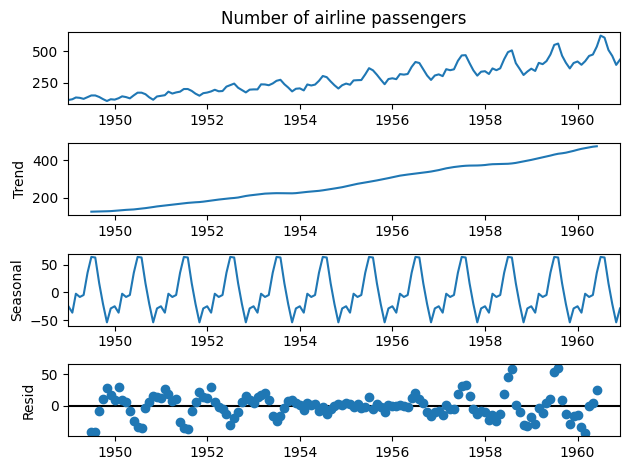

In [21]:
decomposition = sm.tsa.seasonal_decompose(airline, model="additive", period=12)
# Plotting the decomposed time series components
fig = decomposition.plot()

there is a clear linear trend upwards, and a seasonal component with a period of 12.
The notes also show how to extract the autocorrelation function. use plot_acf from
stats_models

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

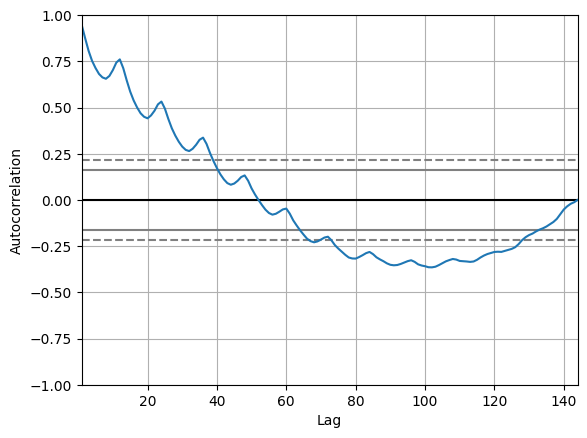

In [22]:
pd.plotting.autocorrelation_plot(airline)

statsmodels can also plot the ACF. There is a peak in the ACF at 12, indicating data 12 months apart are more
correlated than, for example, data eight points apart. Note the longer the lag, the
less useful is the ACF, since it is calculated with fewer and fewer datapoints.
statsmodels plot_acf allows you to specify the number of lags to plot.

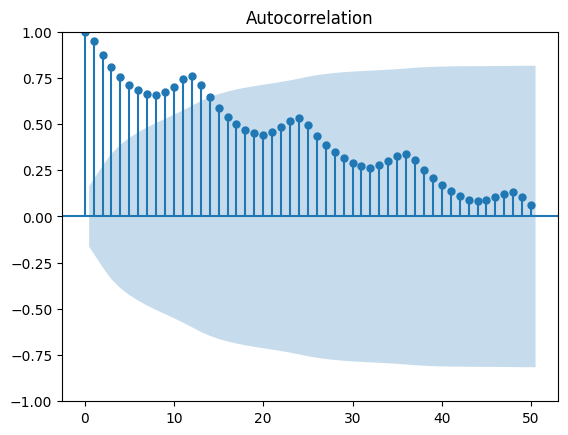

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

plot = plot_acf(airline, lags=50)


Note there are also gradually decreasing peaks at 24, 36 and 48. Clearly, if data 12
points apart are correlated, so will data 24 and 36 months. To remove this effect, it
 is common to plot the partial autocorrelation function. This is the autocorrelation
 with previous autocorrelations factored out. WHY IS THE PEAK AT 13?!?!


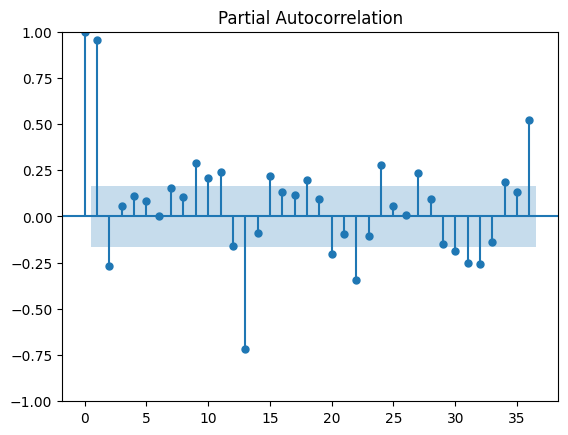

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf

plot = plot_pacf(airline, lags=36)

## Basic Usage, forecasting horizon, naive forecasting

The simplest way of forecasting is to predict the next time period will be
the same as the last. We will use this as an example. aeon is object oriented, so we
create forecasting object to make our predictions. Training is performed with the fit
 function, and predictions are made with the predict function. Suppose we want to use
  a naive forecaster to predict the next value of the airline data. We can do this as


In [34]:
import pandas as pd

from aeon.datasets import load_airline
from aeon.forecasting.naive import NaiveForecaster

airline = load_airline()
nf = NaiveForecaster()
nf.fit(airline)
nf.predict(fh=1)

1961-01    432.0
Freq: M, dtype: float64

you can predict further into the future by adding to the forecasting horizon (fh). To
 predict the next ten values, we can pass an array to fh.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

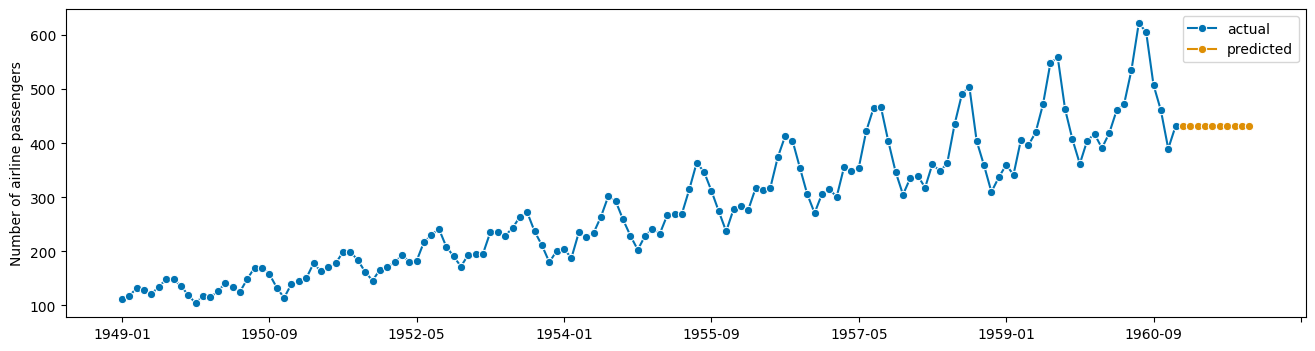

In [38]:
preds = nf.predict(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plot_series(airline, preds, labels=["actual", "predicted"])

we could give our niave forecaster a seasonality parameter, so the predicted value is
 taken as the value 12 months ago.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

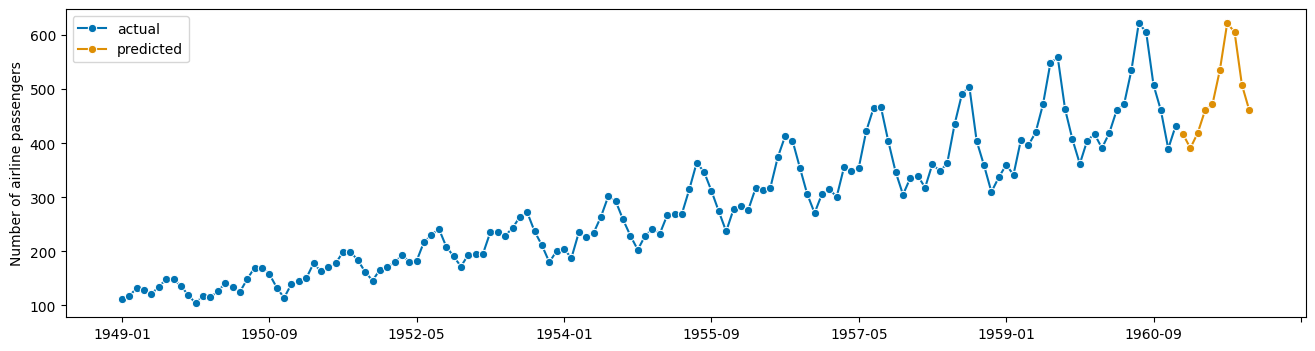

In [40]:
nf = NaiveForecaster(sp=12)
nf.fit(airline)
preds = nf.predict(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plot_series(airline, preds, labels=["actual", "predicted"])

aeon contains a wide range of forecasting models, including those covered on your
course and wrappers for statsmodels. We will show you how to use some of these models.
For a full list, see the aeon documentation.

 ## Assessing the performance of a forecaster (section 3.1)

Measuring the performance of a forecaster requires a measure of difference between
actual and predicted values for a time series. When assessing performance, it is
vital we do not train the model on the values used to assess performance, because
this will introduce bias. Suppose we want to assess the performance of our naive
forecaster with a seasonality of 12. We can do this as follows:

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

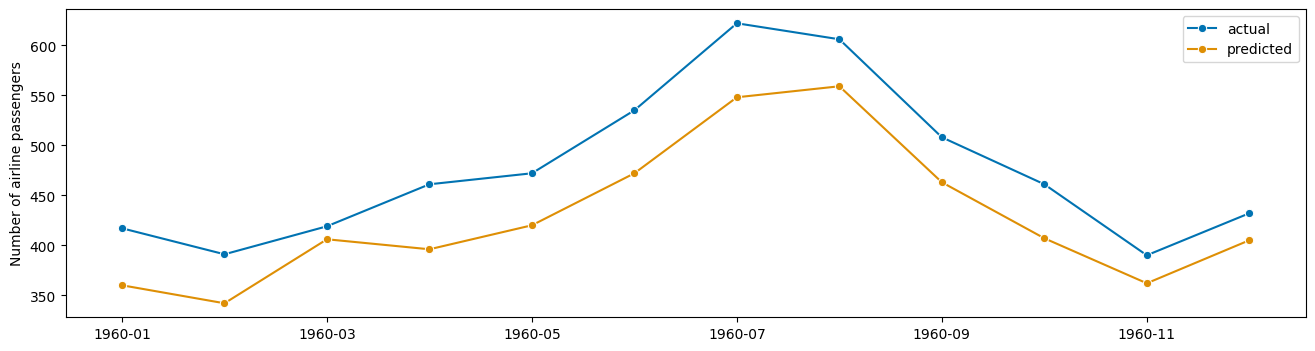

In [45]:
from aeon.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(airline, test_size=12)
nf = NaiveForecaster(sp=12)
nf.fit(y_train)
preds = nf.predict(fh=list(range(1, 13)))
plot_series(y_test, preds, labels=["actual", "predicted"])

We can see the naive forecaster is consistently underestimating. This is because it
takes no account in the increasing trend: it gets the shape correct, but not the
scale. We can quantify this by using one of the performance measures in aeon, such as
the mean absolute error (MAE) and the mean squared error (MSE).

In [46]:
from aeon.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_squared_percentage_error,
)

mae1 = mean_absolute_error(y_test, preds)
mse1 = mean_squared_error(y_test, preds)
mape1 = mean_absolute_percentage_error(y_test, preds)
mspe1 = mean_squared_percentage_error(y_test, preds)
print(f"MAE: {mae1}, MSE: {mse1}, MAPE: {mape1}, MSPE: {mspe1}")

MAE: 47.833333333333336, MSE: 2571.3333333333335, MAPE: 0.09987532920823484, MSPE: 0.011002863793074287


## Exponential Smoothing and Holt-Winter (section 3.2)

Exponential smoothing is a family of forecasting methods that use weighted averages

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

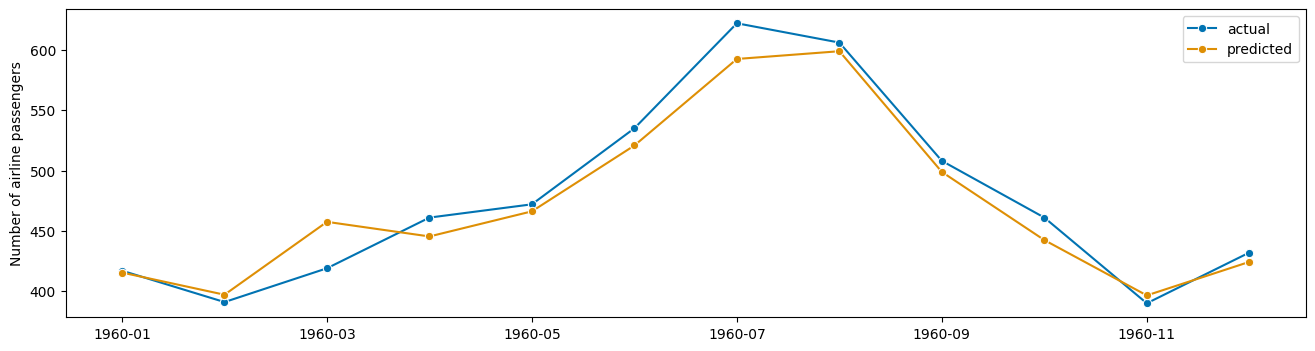

In [49]:
from aeon.forecasting.exp_smoothing import ExponentialSmoothing

esf = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
esf.fit(y_train)
preds = esf.predict(fh=list(range(1, 13)))
plot_series(y_test, preds, labels=["actual", "predicted"])

In [51]:
mae2 = mean_absolute_error(y_test, preds)
mse2 = mean_squared_error(y_test, preds)
mape2 = mean_absolute_percentage_error(y_test, preds)
mspe2 = mean_squared_percentage_error(y_test, preds)
print(
    f"Naive 12 month seasonal: MAE: {mae1}, MSE: {mse1}, MAPE: {mape1}, MSPE: "
    f"{mspe1}"
)
print(
    f"Exponential 12 month seasonal: MAE: {mae2}, MSE: {mse2}, MAPE: {mape2}, MSPE: "
    f"{mspe2}"
)

Naive 12 month seasonal: MAE: 47.833333333333336, MSE: 2571.3333333333335, MAPE: 0.09987532920823484, MSPE: 0.011002863793074287
Exponential 12 month seasonal: MAE: 13.380462475074248, MSE: 288.31721213073314, MAPE: 0.02802823947659527, MSPE: 0.001304495141091013


## ARIMA (section 3.3)
aeon contains a wrapper for pmdarima ARIMA and AutoARIMA forecasters. We can use this to
 fit an
ARIMA model

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

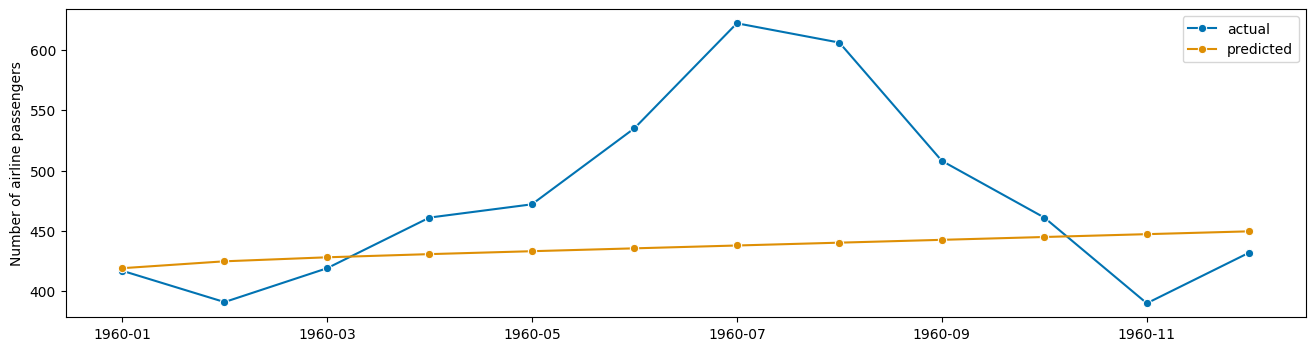

In [57]:
from aeon.forecasting.arima import ARIMA

arima = ARIMA(order=(1, 1, 0))
arima.fit(y_train)
preds = arima.predict(fh=list(range(1, 13)))
plot_series(y_test, preds, labels=["actual", "predicted"])

## Regression in forecasting (section 5)

## Case study:

Leo?


